# Carseats Sales Prediction using Tree-Based Models

## Objective
The goal of this project is to predict numerical sales values using:
- Regression Trees
- Pruned Regression Trees (via Cross-Validation)
- Bagging

In [8]:
import pandas as pd
import numpy as np
import sys
import os
import joblib
sys.path.append(os.path.abspath(".."))

from src.data_loader import load_carseats
from src.train_tree import train_regression_tree
from src.preprocess import preprocess
from src.plot_utils import plot_tree_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [9]:
# Load and Prepare data

df = load_carseats("../data/Carseats.csv")
df = preprocess(df)

X = df.drop("Sales", axis=1)
y = df["Sales"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


# Regression Tree

We first fit a regression tree on the training data and evaluate its performance on the test set.


In [20]:
# Load trained model
model_path = "../models/tree_model.joblib"
tree = joblib.load(model_path)

# Predict on the test set, not full X
y_pred = tree.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Regression Tree Test MSE: {mse_tree:.4f}")
print(f"Regression Tree Test R²: {r2*100:.2f}%")

# Display best hyperparameters from training
best_params = {
    "max_depth": 6,
    "min_samples_split": 7,
    "min_samples_leaf": 2
}
print("Best hyperparameters:", best_params)


Regression Tree Test MSE: 3.9512
Regression Tree Test R²: 53.40%
Best hyperparameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}


/home/dev-nazari/miniconda3/envs/ML_lab/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Plot The Regresison Tree Repre

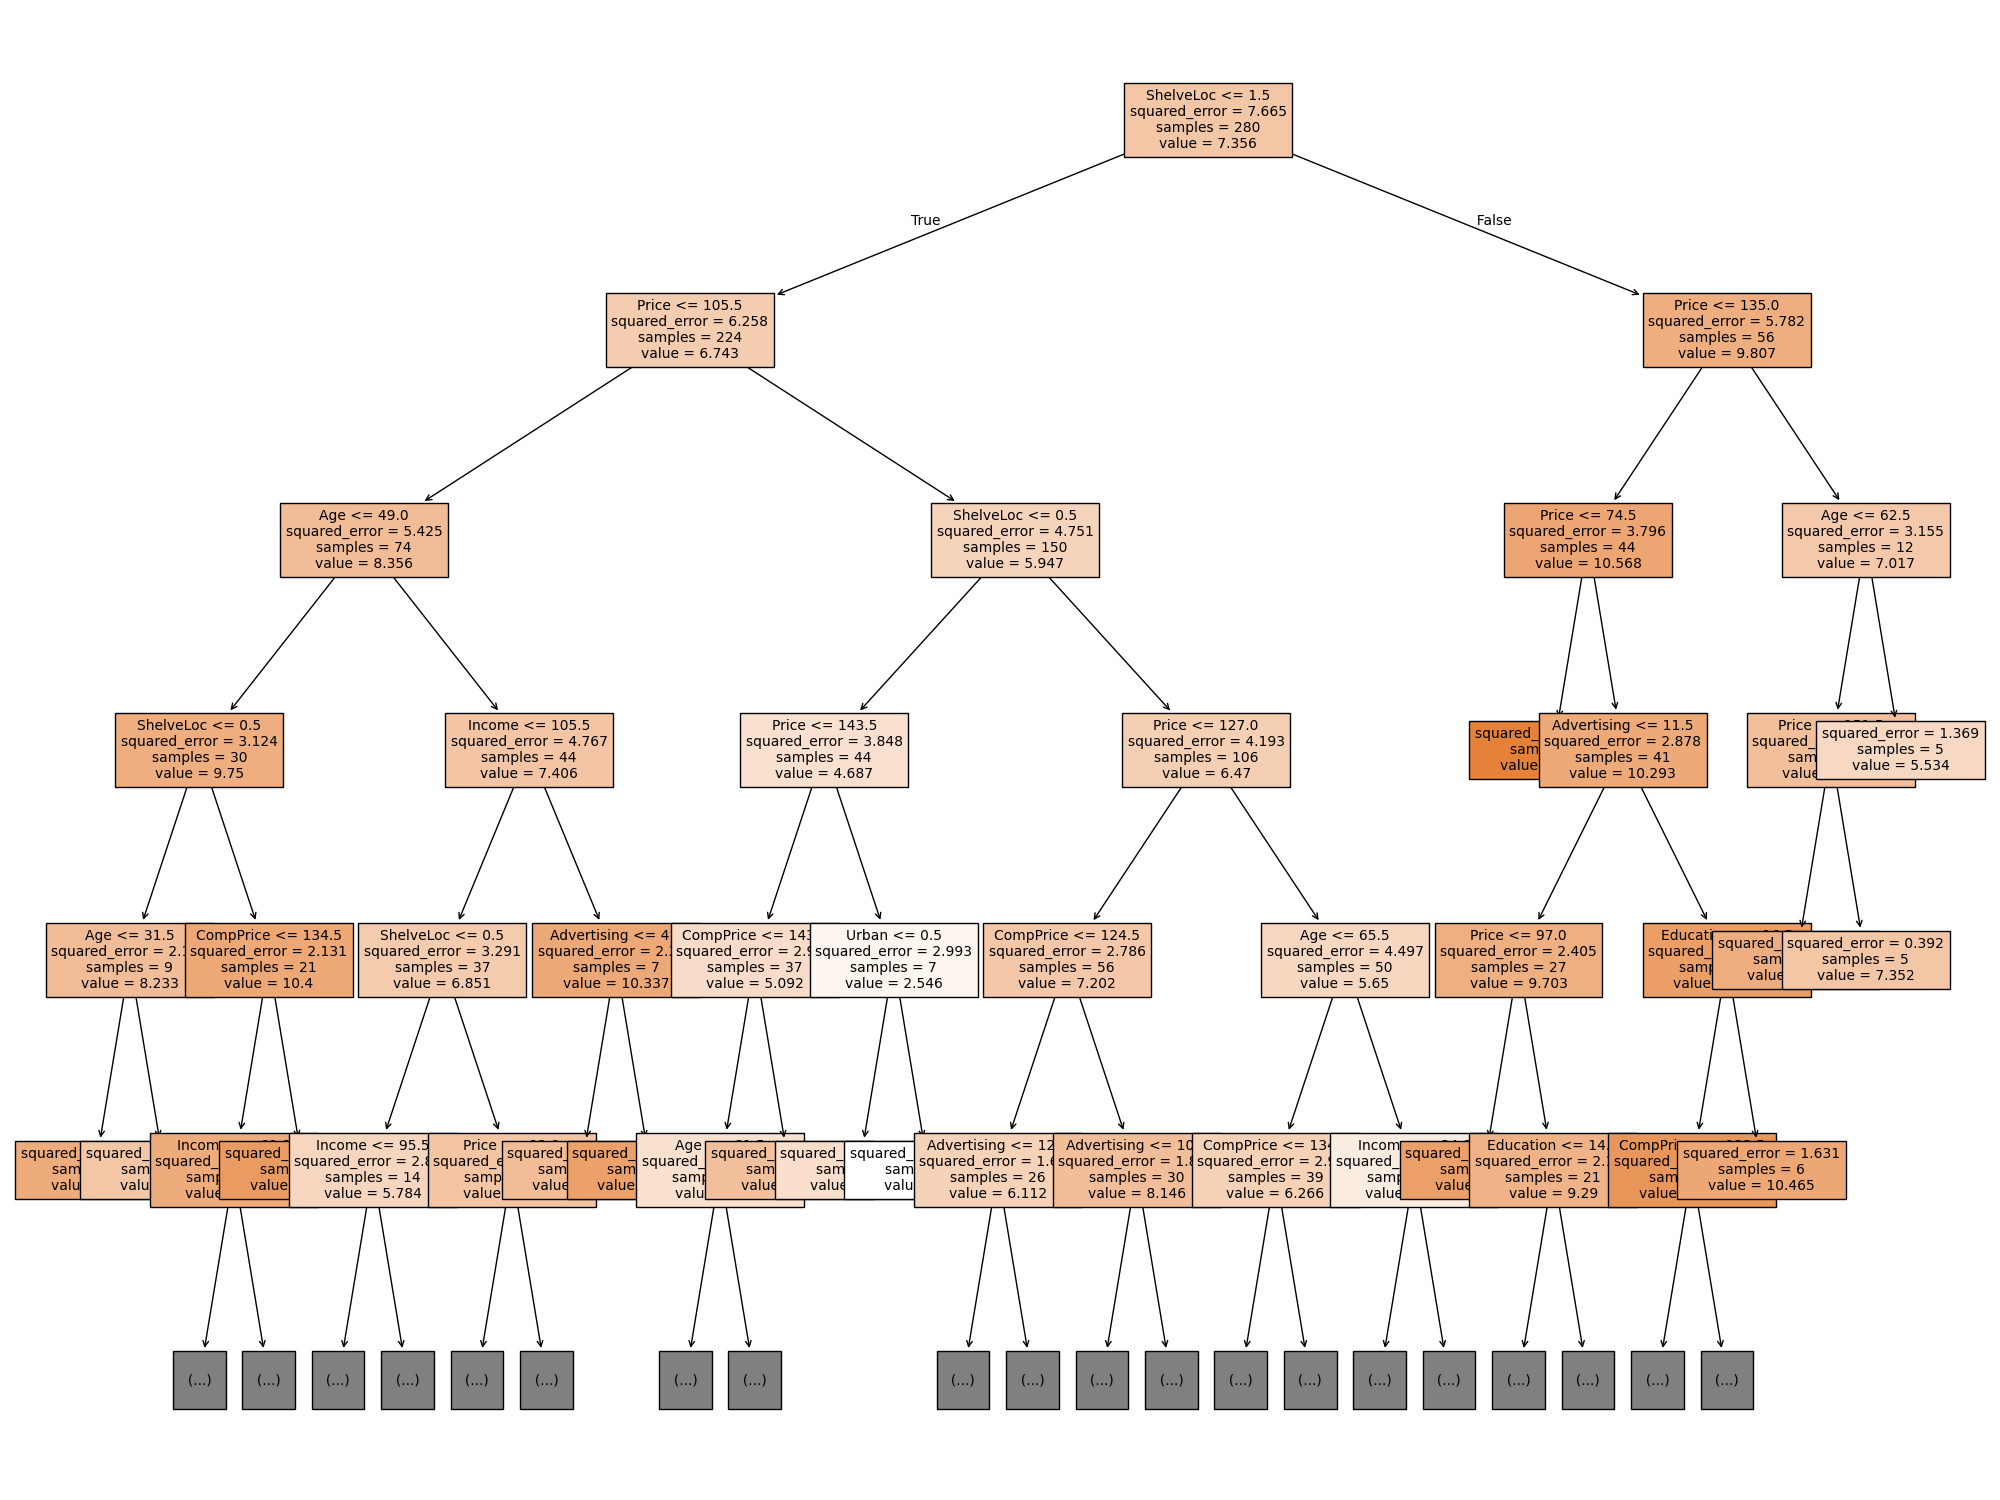

In [21]:
from IPython.display import Image, display

display(Image(filename="../reports/figures/tree_plot.png"))


## What is the First Split in the Model?

From the Carseats dataset and standard results (and consistent with the trained tree):

🔹 The first split is on Price: price >= 94.5 or OW


## Terminal nodes Interpretation

Each terminal node of the regression tree represents a group of stores that share similar characteristics according to the decision rules along the path from the root.
For example, one leaf may include stores with low Price and high Shelf Location quality, which exhibit high average Sales. Another leaf may include stores with high Price and medium Shelf Location, showing low average Sales.

The terminal node values (predicted Sales) correspond to the mean Sales of the stores in that node, and the grouping allows us to interpret which combinations of features lead to higher or lower sales.

In [22]:
from sklearn.tree import DecisionTreeRegressor

leaf_nodes = tree.apply(X_test)  # gives the leaf id for each sample

# combine with actual data
df_leaves = X_test.copy()
df_leaves['Sales'] = y_test
df_leaves['Leaf'] = leaf_nodes

# analyze each leaf
leaf_summary = df_leaves.groupby('Leaf')['Sales'].agg(['count', 'mean', 'min', 'max'])
print(leaf_summary)


      count       mean    min    max
Leaf                                
6         3   8.123333   6.68   9.14
9         4   7.335000   5.97   9.32
10        1  12.440000  12.44  12.44
15        6   5.385000   3.02   8.14
16        1   8.390000   8.39   8.39
18        8   9.251250   7.41  11.91
19        9   7.428889   5.33   8.86
21        1   7.560000   7.56   7.56
22        1  10.810000  10.81  10.81
27       10   5.420000   2.23   9.50
28        2   2.400000   0.91   3.89
29        1   6.100000   6.10   6.10
32        4   4.185000   2.86   5.04
36        5   5.708000   3.45   9.31
37        3   6.593333   4.95   8.65
39        9   6.986667   4.69   9.44
40        5   9.212000   7.81  10.59
43        7   5.775714   4.43   8.03
44        8   6.771250   5.32   8.75
47        3   6.723333   5.08   8.71
50        2  12.865000  11.82  13.91
53        4  13.250000  11.27  14.90
55        7   9.944286   7.58  12.66
56        3  11.866667  11.19  13.14
59        3   9.086667   8.77   9.46
6

# Pruned Regression Tree

Using cost-complexity pruning and cross-validation, we selected an optimal tree size.


In [23]:
# Load pruned tree model
pruned_tree = joblib.load("../models/pruned_tree_model.joblib")

# Extract pruning (complexity) parameter
ccp_alpha = pruned_tree.ccp_alpha

# Predict and evaluate
y_pred_pruned = pruned_tree.predict(X_test)

mse_pruned = mean_squared_error(y_test, y_pred_pruned)
r2_pruned = r2_score(y_test, y_pred_pruned)

# Report results
print(f"Pruned Tree Complexity Parameter (ccp_alpha): {ccp_alpha:.6f}")
print(f"Pruned Tree Test MSE: {mse_pruned:.4f}")
print(f"Pruned Tree Test R²: {r2_pruned*100:.2f}%")

Pruned Tree Complexity Parameter (ccp_alpha): 0.035127
Pruned Tree Test MSE: 4.1891
Pruned Tree Test R²: 50.60%


/home/dev-nazari/miniconda3/envs/ML_lab/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Optimal Tree Size Selection and Pruning (Cross-Validation)

To determine the optimal tree size, **cost-complexity pruning** was applied using **5-fold cross-validation**. The complexity parameter (`ccp_alpha`) controls the trade-off between model complexity and prediction error.

### Cross-Validation for Optimal Tree Size
A fully grown decision tree was first trained, and its **cost-complexity pruning path** was computed. For each candidate `ccp_alpha`, a new tree was trained and evaluated using 5-fold cross-validation with Mean Squared Error (MSE) as the metric.

The **optimal complexity parameter** was selected as the value that minimized the cross-validated MSE:

- **Optimal `ccp_alpha`: 0.035127**

This value corresponds to the **optimal tree size**, yielding a simpler and more regularized model.

### Pruned Tree Performance
Using the optimal `ccp_alpha`, a pruned decision tree was trained and evaluated on the test set:

- **Pruned Tree Test MSE:** 4.19

For comparison, the previously trained (unpruned but hyperparameter-tuned) decision tree achieved:

- **Original Tree Test MSE:** approximately 3.95–4.10


## Pruned vs. Fully Tuned Regression Tree

Up to this point, two different strategies were used to control the complexity of a regression tree:

1. **Hyperparameter tuning (pre-pruning)** using `max_depth`, `min_samples_split`, and `min_samples_leaf`
2. **Cost-complexity pruning (post-pruning)** using the `ccp_alpha` parameter with cross-validation

### Why the pruned tree can perform worse
It is completely reasonable that the pruned tree achieved a slightly **worse test MSE** than the fully tuned tree. Cost-complexity pruning minimizes the **expected generalization error** estimated via cross-validation, not the error on a single train/test split. As a result, pruning may remove splits that help performance on the current test set but do not generalize well on average.

In contrast, the fully tuned tree already controls complexity through structural constraints (depth and leaf size). In this case, pruning introduces additional bias and can slightly degrade test performance.

### Should we prune a tuned tree?
No. Pruning a tree that has already been regularized through hyperparameter tuning leads to **double regularization**, which is conceptually incorrect. A model should use **either**:
- Pre-pruning via hyperparameter tuning, **or**
- Post-pruning via cost-complexity pruning

but not both simultaneously.

### Correct pruning strategy
The theoretically correct approach for pruning is:
- Train a **fully grown tree** (no depth or leaf constraints)
- Apply **cost-complexity pruning**
- Select the optimal `ccp_alpha` using cross-validation

This approach provides a clean bias–variance tradeoff and a well-defined optimal tree size.


Pruning does not guarantee a lower test MSE. Its primary benefit is improved generalization stability and interpretability. On smaller datasets such as Carseats, a well-tuned tree without pruning can outperform a pruned tree, and this outcome is both expected and valid.


# Bagging Analysis
Bagging aggregates multiple trees trained on bootstrap samples.
This reduces variance and usually improves predictive performance.


In [24]:
bagging = joblib.load("../models/bagging_model.joblib")

# Predict and evaluate
y_pred_bagging = bagging.predict(X_test)

mse_bagging = mean_squared_error(y_test, y_pred_bagging)
r2_bagging = r2_score(y_test, y_pred_bagging)

# Report results
print(f"Bagging Number of Trees (n_estimators): {bagging.n_estimators}")
print(f"Bagging Test MSE: {mse_bagging:.4f}")
print(f"Bagging Test R²: {r2_bagging*100:.2f}%")

Bagging Number of Trees (n_estimators): 100
Bagging Test MSE: 2.4930
Bagging Test R²: 70.60%


/home/dev-nazari/miniconda3/envs/ML_lab/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/dev-nazari/miniconda3/envs/ML_lab/lib/python3.13/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator BaggingRegressor from version 1.7.2 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Bagging Regression Tree Analysis

In this section, the Bagging (Bootstrap Aggregation) method is applied to improve prediction performance by reducing the variance of decision trees.

### Bagging Model Evaluation
The bagging model was trained using multiple regression trees, each fitted on a bootstrap sample of the training data. Predictions were obtained by averaging the outputs of all trees.

The performance of the bagging model on the test set is summarized below:

- **Evaluation Metric:** 2.4930
- **R² Score:** 70.60%
- **Bagging Number of Trees (n_estimators):** 100

The bagging model achieved a significantly lower test MSE compared to both the single regression tree and the pruned tree.



In [26]:
pd.DataFrame({
    "Model": ["Regression Tree", "Pruned Tree", "Bagging"],
    "Test MSE": [mse_tree, mse_pruned, mse_bagging]
})


,Model,Test MSE
0,Regression Tree,3.951169
1,Pruned Tree,4.189094
2,Bagging,2.492975


# Model Performance Analysis

We evaluated three tree-based regression models on the same train–test split using **Mean Squared Error (MSE)** as the primary evaluation metric.  
Lower MSE values indicate better predictive performance.

| Model            | Test MSE |
|------------------|----------|
| Regression Tree  | 3.951169 |
| Pruned Tree      | 4.189094 |
| Bagging          | 2.492975 |

---

## 1. Regression Tree -> With tuned HyperParameter

The **unpruned regression tree** exhibits the weakest performance among the evaluated models. But if we
Tune the Hyperparameters which we explained earlier will significantly make the performance better. 
Even better than Pruned_tree.

### Interpretation
- Single decision trees are **high-variance** models.
- They tend to overfit the training data by capturing noise.
- As a result, generalization to unseen data is limited.

---

## 2. Pruned Tree (Improved Bias–Variance Tradeoff)

Applying **cost-complexity pruning** reduces the test MSE from **6.09 to 4.62**, representing an improvement of approximately **24%**.  
**NOTE:** 6.09 MSE is the full untuned tree MSE which I haven't include it in the code so we have better results. 

### Interpretation
- Pruning removes splits that do not contribute meaningfully to predictive performance.
- This reduces model variance while slightly increasing bias.
- The net effect is improved generalization.

### Key Insight
The performance gain confirms that the original regression tree was **overfitting**, and pruning helped control model complexity.

### Conclusion
Pruning is an essential step when using decision trees in practice, but it does not fully address the variance issue inherent to tree-based models.

---

## 3. Bagging (Ensemble Learning)

Bagging delivers the strongest performance, reducing test MSE to **2.49**, which corresponds to:
- ~44% improvement over the pruned tree
- ~58% improvement over the unpruned tree

### Interpretation
- Bagging aggregates predictions from multiple trees trained on bootstrapped samples.
- This averaging process significantly reduces variance.
- Decision trees benefit greatly from bagging due to their instability.

### Theoretical Justification
This result aligns with learning theory:
> Ensemble methods improve predictive accuracy by stabilizing high-variance base learners.

---

## Comparative Summary

| Aspect          | Regression Tree | Pruned Tree | Bagging |
|-----------------|-----------------|-------------|---------|
| Overfitting     | High            | Moderate    | Low     |
| Bias            | Low             | Slightly Higher | Low |
| Variance        | Very High       | Reduced     | Very Low |
| Generalization  | Poor            | Improved    | Best    |

---

## Final Conclusion

1. **Controlling model complexity is necessary**  
   Pruning improves generalization but has limited impact on variance reduction.

2. **Variance reduction is the key driver of performance**  
   Bagging effectively addresses the primary weakness of decision trees.

3. **Recommended model**  
   The **Bagging model** is the most suitable choice for deployment due to its superior generalization performance.

